In [2]:
#Importing Necessary Libarires
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

import warnings


### Dataset Extraction and Exploration

In [3]:
# Reading the Dataset
HCHO_data = pd.read_csv('Cleaned_HCHO_Data.csv')

# Basic Info
HCHO_data.info()
HCHO_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12430 entries, 0 to 12429
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HCHO Reading  12430 non-null  float64
 1   Location      12430 non-null  object 
 2   Current Date  12430 non-null  object 
 3   Next Date     12430 non-null  object 
dtypes: float64(1), object(3)
memory usage: 388.6+ KB


,HCHO Reading,Location,Current Date,Next Date
0,0.000197,Colombo Proper,2019-01-01,2019-01-02
1,0.000263,Colombo Proper,2019-01-02,2019-01-03
2,0.000099,Colombo Proper,2019-01-03,2019-01-04
3,0.000210,Colombo Proper,2019-01-04,2019-01-05
4,0.000179,Colombo Proper,2019-01-05,2019-01-06


(12430, 4)

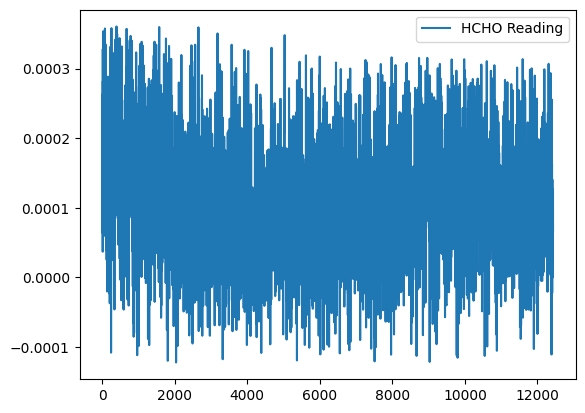

In [4]:
# Plotting the basic data
HCHO_data.plot()

# Dataframe Shape
HCHO_data.shape

## Staionary of the Time Series

Stationarity refers to a situation where the statistical properties like the mean, variance, and autocorrelation—are constant over time. This property is important because many statistical methods and models for time series analysis require the data to be stationary in order to continue with modelling and interpriting the results.

In [5]:
# Convert 'Current Date' to datetime type
HCHO_data['Current Date'] = pd.to_datetime(HCHO_data['Current Date'])

# Set 'Current Date' as the index of the DataFrame
HCHO_data.set_index('Current Date', inplace=True)

### Time-Series Plot (All Cities)

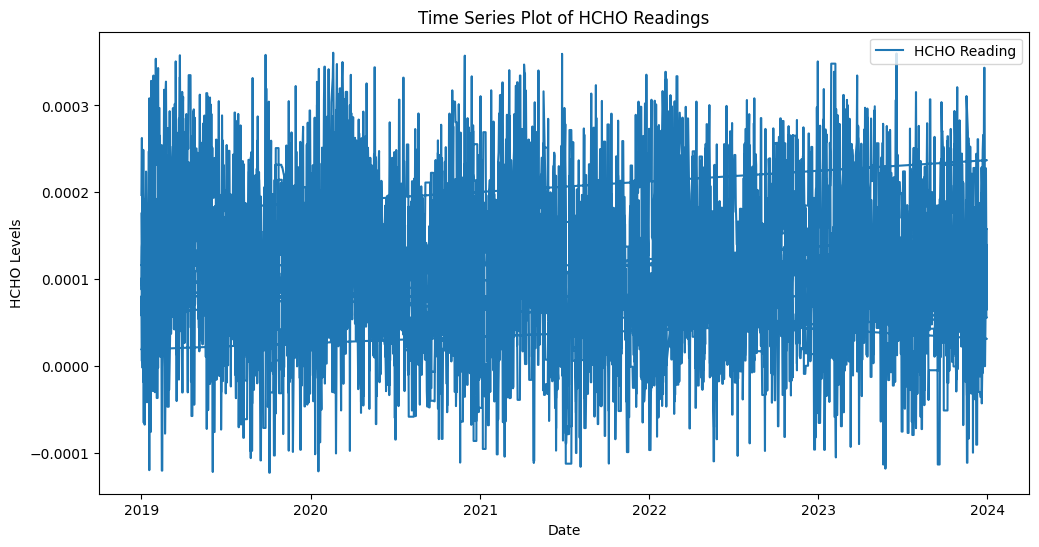

In [6]:
# Plotting Time Series Plot
plt.figure(figsize=(12, 6))
plt.plot(HCHO_data['HCHO Reading'], label='HCHO Reading')
plt.title('Time Series Plot of HCHO Readings')
plt.xlabel('Date')
plt.ylabel('HCHO Levels')
plt.legend()
plt.show()

Based on this plot we can see the data points are over the time is staionary Let's consider fewer other plots to see the stationary of the dataset.

#### ACF Plot (Auto Correlation Function) (All Cities)

<Figure size 1200x600 with 0 Axes>

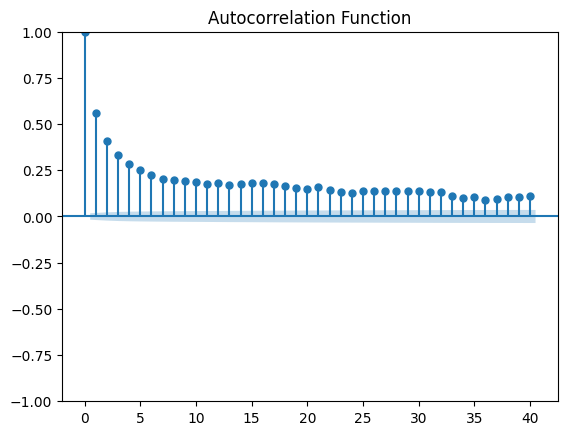

In [7]:
# Plot ACF
plt.figure(figsize=(12, 6))
plot_acf(HCHO_data['HCHO Reading'], lags=40, alpha=0.05)
plt.title('Autocorrelation Function')
plt.show()

### PACF Plot (Partial-Auto Correlation Function) (All Cities)

<Figure size 1200x600 with 0 Axes>

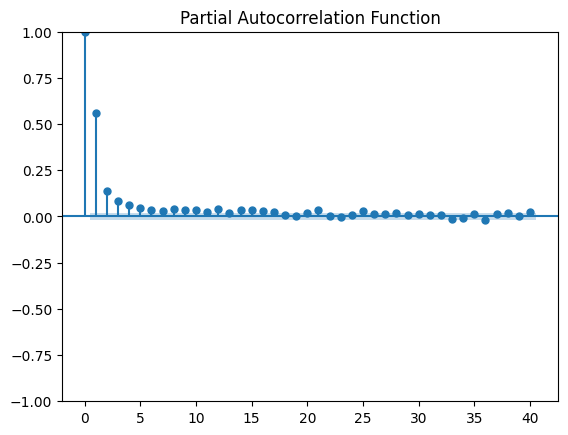

In [8]:
# Plot PACF
plt.figure(figsize=(12, 6))
plot_pacf(HCHO_data['HCHO Reading'], lags=40, alpha=0.05)
plt.title('Partial Autocorrelation Function')
plt.show()

### Rolling Statictics Plot

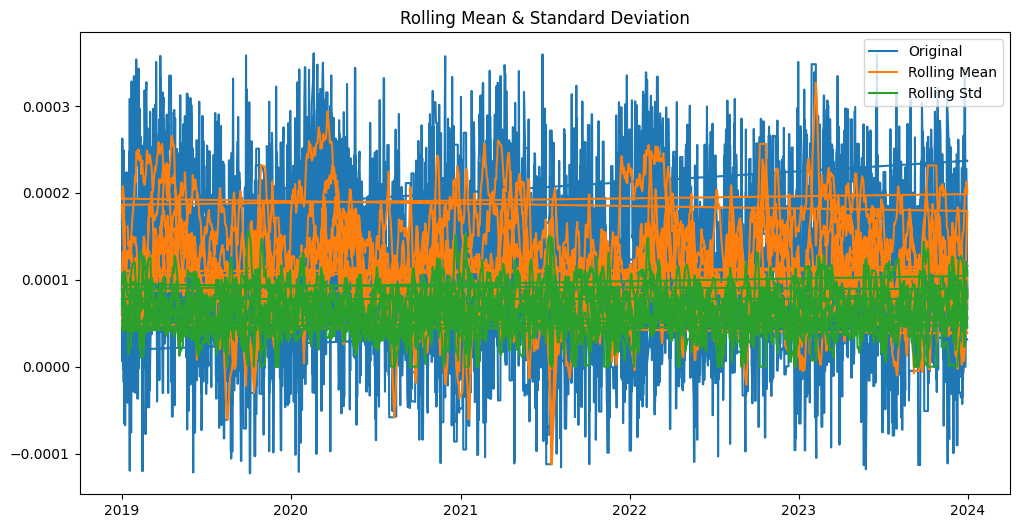

In [9]:
# Rolling Statistics Plot
rolling_mean = HCHO_data['HCHO Reading'].rolling(window=12).mean()
rolling_std = HCHO_data['HCHO Reading'].rolling(window=12).std()

plt.figure(figsize=(12, 6))
plt.plot(HCHO_data['HCHO Reading'], label='Original')
plt.plot(rolling_mean, label='Rolling Mean')
plt.plot(rolling_std, label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()


In [10]:
# Augmented Dickey-Fuller Test
adf_result = adfuller(HCHO_data['HCHO Reading'])

# Extract and print ADF statistic and p-value
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

# Check if the p-value is less than the significance level
if adf_result[1] < 0.05:
    print("The time series is likely stationary (Reject null hypothesis)")
else:
    print("The time series is likely non-stationary (Fail to reject null hypothesis)")

ADF Statistic: -11.434209229491477
p-value: 6.406701833763946e-21
The time series is likely stationary (Reject null hypothesis)


From These plots and results interpret that this dataframe is likely stationary. Therefore we can reject the null hypothesis and prove that this dataframe is good to fit with SARIMA Model.

## SARIMA Model Fitting

### Colombo Proper

#### Data Splitting

In [11]:
#Splitting the dataset into train and test sets
split_ratio = 0.8 # 80% of data to train

colombo_data = HCHO_data[HCHO_data['Location'] == 'Colombo Proper']
train_size = int(len(colombo_data) * split_ratio)
train_data_colombo, test_data_colombo = colombo_data[0:train_size], colombo_data[train_size:]

print("Full Data Size:-", colombo_data.shape)
print("Train Data Size :-", train_data_colombo.shape)
print("Test Data Size :-", test_data_colombo.shape)

Full Data Size:- (1766, 3)
Train Data Size :- (1412, 3)
Test Data Size :- (354, 3)


#### Model Training and Evaluation

In [12]:
# Suppress warnings
warnings.filterwarnings("ignore")

# Fitting the SARIMA Model
# Fit SARIMA model to the training data
sarima_model = SARIMAX(train_data_colombo['HCHO Reading'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()

# Generate forecasts for the test set
test_forecast = sarima_result.forecast(steps=len(test_data_colombo))

# Calculate evaluation metrics
mse = mean_squared_error(test_data_colombo['HCHO Reading'], test_forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_colombo['HCHO Reading'], test_forecast)

# Print evaluation metrics
print("\nEvaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")



Evaluation Metrics:
Mean Squared Error (MSE): 1.2436663752562711e-07
Root Mean Squared Error (RMSE): 0.0003526565432905323
Mean Absolute Error (MAE): 0.0003058374921713632


#### Predicting HCHO Levels of Next 10 Days

In [ ]:
# Generate forecasts for the next 10 days by fitting entire dataset for the model
sarima_model = SARIMAX(colombo_data['HCHO Reading'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()

forecast_10days = sarima_result.forecast(steps=11)

# Print the forecasted values
print("\nForecasted HCHO levels for the next 10 days:")
print(forecast_10days)


Forecasted HCHO levels for the next 10 days:
1766    0.000145
1767    0.000157
1768    0.000223
1769    0.000231
1770    0.000133
1771    0.000211
1772    0.000194
1773    0.000129
1774    0.000125
1775    0.000076
1776    0.000151
Name: predicted_mean, dtype: float64


#### Plotting Results

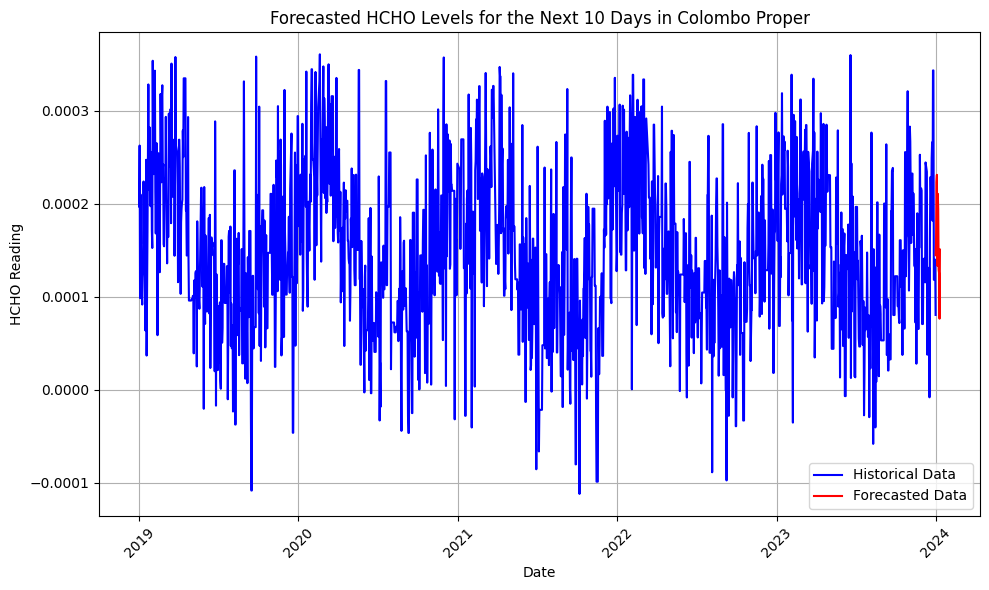

In [ ]:
# Plot historical data
plt.figure(figsize=(10, 6))
plt.plot(colombo_data.index, colombo_data['HCHO Reading'], label='Historical Data', color='blue')

# Plot forecasted values for the next 10 days
forecast_dates = pd.date_range(start=colombo_data.index[-1], periods=11)
plt.plot(forecast_dates, forecast_10days, label='Forecasted Data', color='red')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.title('Forecasted HCHO Levels for the Next 10 Days in Colombo Proper')
plt.legend()
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()


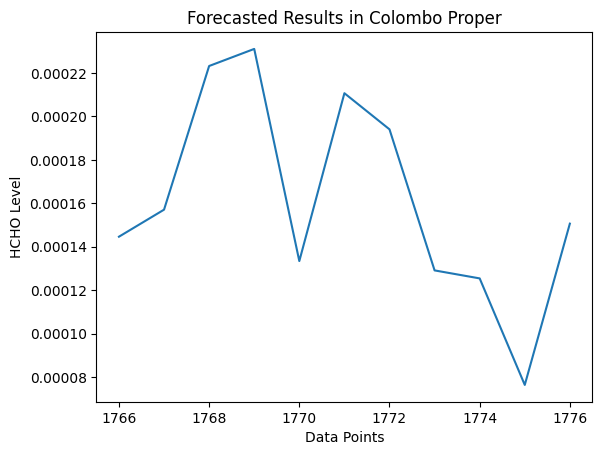

In [ ]:
# Forecasted Results
plt.title("Forecasted Results in Colombo Proper")
plt.xlabel('Data Points')
plt.ylabel('HCHO Level')
plt.plot(forecast_10days)

### Jaffna Proper

#### Data Splitting

In [ ]:
#Splitting the dataset into train and test sets
split_ratio = 0.8 

jaffna_data = HCHO_data[HCHO_data['Location'] == 'Jaffna Proper']
train_size = int(len(jaffna_data) * split_ratio)
train_data_jaffna, test_data_jaffna = jaffna_data[0:train_size], jaffna_data[train_size:]

print("Full Data Size:-", jaffna_data.shape)
print("Train Data Size :-", train_data_jaffna.shape)
print("Test Data Size :-", test_data_jaffna.shape)


Full Data Size:- (1785, 3)
Train Data Size :- (1428, 3)
Test Data Size :- (357, 3)


#### Model Training and Prediction

In [ ]:
# Fitting the SARIMA Model
# Fit SARIMA model to the training data
sarima_model = SARIMAX(train_data_jaffna['HCHO Reading'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()

# Generate forecasts for the test set
test_forecast = sarima_result.forecast(steps=len(test_data_jaffna))

# Calculate evaluation metrics
mse = mean_squared_error(test_data_jaffna['HCHO Reading'], test_forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_jaffna['HCHO Reading'], test_forecast)

# Print evaluation metrics
print("\nEvaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")



Evaluation Metrics:
Mean Squared Error (MSE): 1.1228447623489302e-07
Root Mean Squared Error (RMSE): 0.0003350887587414609
Mean Absolute Error (MAE): 0.0002850046771371725


#### Forecasting next 10 days in the full dataset

In [ ]:
# Generate forecasts for the next 10 days by fitting entire dataset for the model
sarima_model = SARIMAX(jaffna_data['HCHO Reading'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()

forecast_10days = sarima_result.forecast(steps=11)

# Print the forecasted values
print("\nForecasted HCHO levels for the next 10 days:")
print(forecast_10days)


Forecasted HCHO levels for the next 10 days:
1785    0.000101
1786    0.000089
1787    0.000085
1788    0.000112
1789    0.000045
1790    0.000057
1791    0.000056
1792    0.000088
1793    0.000095
1794    0.000099
1795    0.000088
Name: predicted_mean, dtype: float64


#### Data Plotting Results

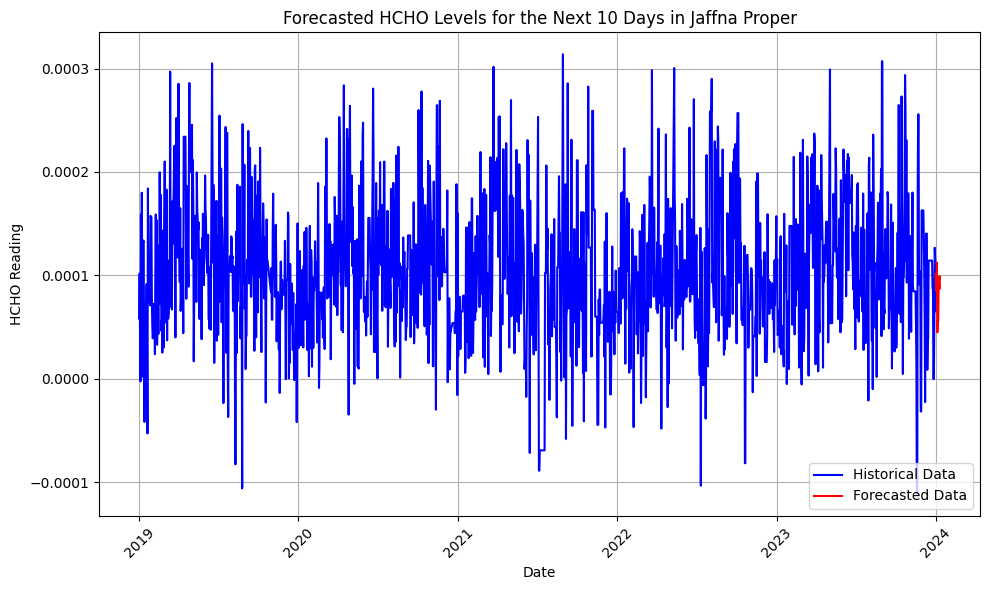

In [ ]:
# Plot historical data
plt.figure(figsize=(10, 6))
plt.plot(jaffna_data.index, jaffna_data['HCHO Reading'], label='Historical Data', color='blue')

# Plot forecasted values for the next 10 days
forecast_dates = pd.date_range(start=jaffna_data.index[-1], periods=11)
plt.plot(forecast_dates, forecast_10days, label='Forecasted Data', color='red')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.title('Forecasted HCHO Levels for the Next 10 Days in Jaffna Proper')
plt.legend()
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()


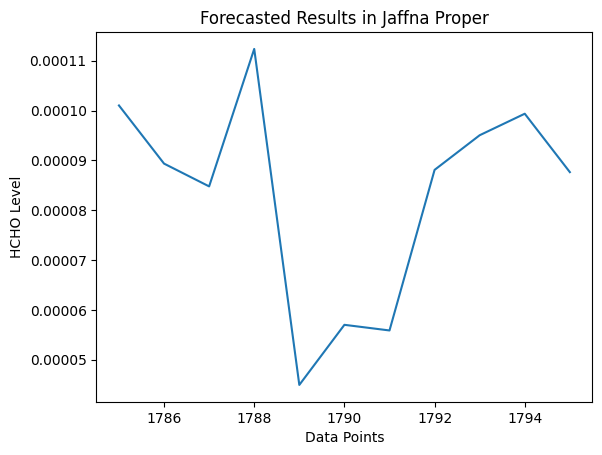

In [ ]:
# Forecasted Results
plt.title("Forecasted Results in Jaffna Proper")
plt.xlabel('Data Points')
plt.ylabel('HCHO Level')
plt.plot(forecast_10days)

### Deniyaya, Matara

#### Data Splitting

In [ ]:
#Splitting the dataset into train and test sets
split_ratio = 0.8 

matara_data = HCHO_data[HCHO_data['Location'] == 'Deniyaya, Matara']
train_size = int(len(matara_data) * split_ratio)
train_data_matara, test_data_matara = matara_data[0:train_size], matara_data[train_size:]

print("Full Data Size:-", matara_data.shape)
print("Train Data Size :-", train_data_matara.shape)
print("Test Data Size :-", test_data_matara.shape)

Full Data Size:- (1777, 3)
Train Data Size :- (1421, 3)
Test Data Size :- (356, 3)


#### Model Trainining and Prediction

In [ ]:
# Fitting the SARIMA Model
# Fit SARIMA model to the training data
sarima_model = SARIMAX(train_data_matara['HCHO Reading'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()

# Generate forecasts for the test set
test_forecast = sarima_result.forecast(steps=len(test_data_matara))

# Calculate evaluation metrics
mse = mean_squared_error(test_data_matara['HCHO Reading'], test_forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_matara['HCHO Reading'], test_forecast)

# Print evaluation metrics
print("\nEvaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")



Evaluation Metrics:
Mean Squared Error (MSE): 1.0249583117857301e-08
Root Mean Squared Error (RMSE): 0.00010124022480149529
Mean Absolute Error (MAE): 7.970321204103042e-05


#### Forecasting next 10 days

In [ ]:
# Generate forecasts for the next 10 days by fitting entire dataset for the model
sarima_model = SARIMAX(matara_data['HCHO Reading'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()

forecast_10days = sarima_result.forecast(steps=11)

# Print the forecasted values
print("\nForecasted HCHO levels for the next 10 days:")
print(forecast_10days)


Forecasted HCHO levels for the next 10 days:
1777    0.000156
1778    0.000121
1779    0.000134
1780    0.000110
1781    0.000106
1782    0.000075
1783    0.000118
1784    0.000166
1785    0.000150
1786    0.000163
1787    0.000130
Name: predicted_mean, dtype: float64


#### Plotting Results

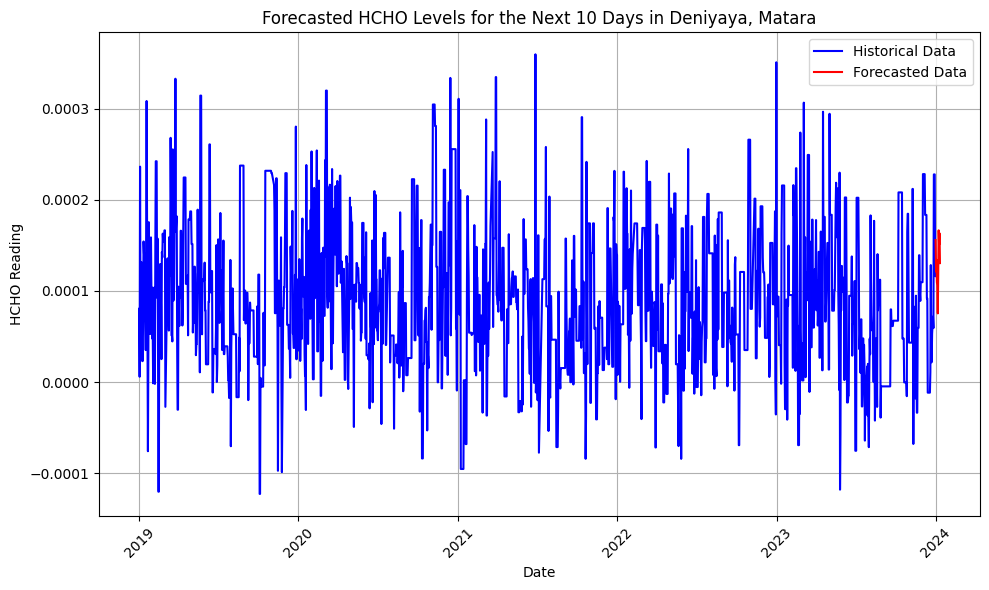

In [ ]:
# Plot historical data
plt.figure(figsize=(10, 6))
plt.plot(matara_data.index, matara_data['HCHO Reading'], label='Historical Data', color='blue')

# Plot forecasted values for the next 10 days
forecast_dates = pd.date_range(start=matara_data.index[-1], periods=11)
plt.plot(forecast_dates, forecast_10days, label='Forecasted Data', color='red')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.title('Forecasted HCHO Levels for the Next 10 Days in Deniyaya, Matara')
plt.legend()
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()


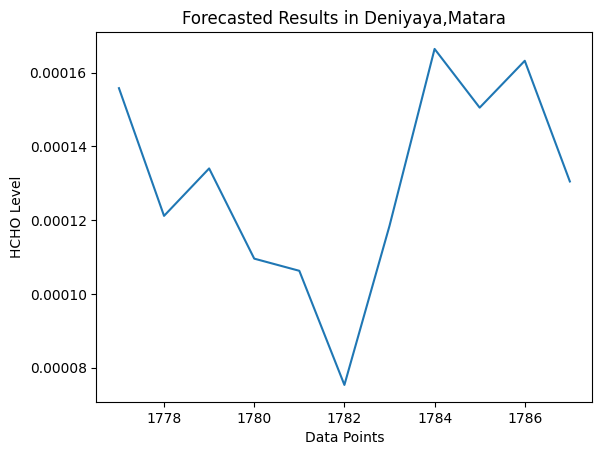

In [ ]:
# Forecasted Results
plt.title("Forecasted Results in Deniyaya,Matara")
plt.xlabel('Data Points')
plt.ylabel('HCHO Level')
plt.plot(forecast_10days)

### Nuwara Eliya Proper

#### Data Splitting

In [ ]:
#Splitting the dataset into train and test sets
split_ratio = 0.8 

nuwaraeliya_data = HCHO_data[HCHO_data['Location'] == 'Nuwara Eliya Proper']
train_size = int(len(nuwaraeliya_data) * split_ratio)
train_data_nuwaraeliya, test_data_nuwaraeliya = nuwaraeliya_data[0:train_size], nuwaraeliya_data[train_size:]

print("Full Data Size:-", nuwaraeliya_data.shape)
print("Train Data Size :-", train_data_nuwaraeliya.shape)
print("Test Data Size :-", test_data_nuwaraeliya.shape)

Full Data Size:- (1810, 3)
Train Data Size :- (1448, 3)
Test Data Size :- (362, 3)


#### Model Training and Prediction

In [ ]:
# Fitting the SARIMA Model
# Fit SARIMA model to the training data
sarima_model = SARIMAX(train_data_nuwaraeliya['HCHO Reading'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()

# Generate forecasts for the test set
test_forecast = sarima_result.forecast(steps=len(test_data_nuwaraeliya))

# Calculate evaluation metrics
mse = mean_squared_error(test_data_nuwaraeliya['HCHO Reading'], test_forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_nuwaraeliya['HCHO Reading'], test_forecast)

# Print evaluation metrics
print("\nEvaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")



Evaluation Metrics:
Mean Squared Error (MSE): 6.126377165568567e-07
Root Mean Squared Error (RMSE): 0.0007827117710606227
Mean Absolute Error (MAE): 0.0007023442015224193


#### Forecasting next 10 days

In [ ]:
# Generate forecasts for the next 10 days by fitting entire dataset for the model
sarima_model = SARIMAX(nuwaraeliya_data['HCHO Reading'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()

forecast_10days = sarima_result.forecast(steps=11)

# Print the forecasted values
print("\nForecasted HCHO levels for the next 10 days:")
print(forecast_10days)


Forecasted HCHO levels for the next 10 days:
1810    0.000228
1811    0.000226
1812    0.000230
1813    0.000290
1814    0.000291
1815    0.000315
1816    0.000315
1817    0.000313
1818    0.000309
1819    0.000277
1820    0.000278
Name: predicted_mean, dtype: float64


#### Plotting Results

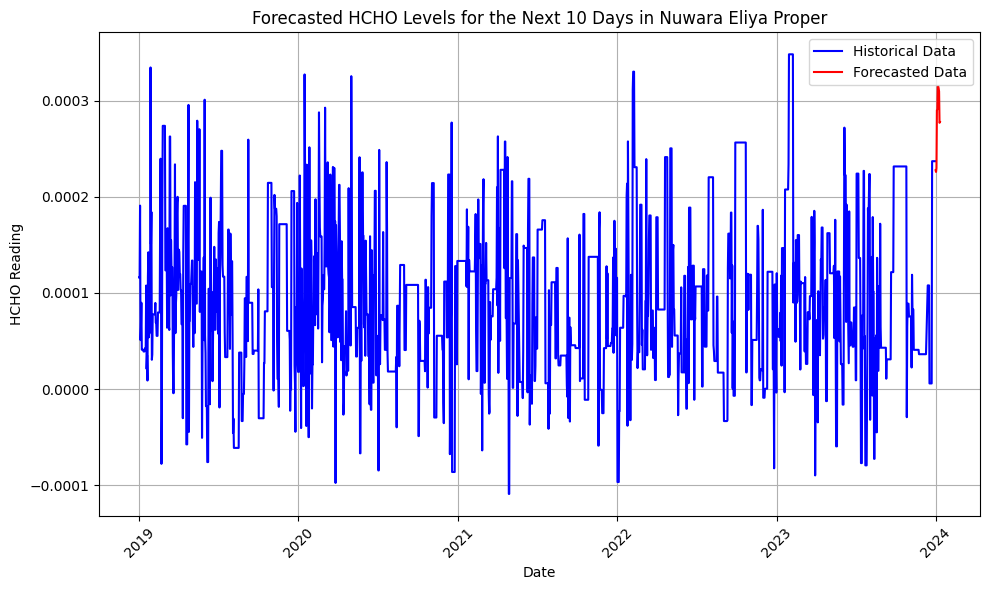

In [ ]:
# Plot historical data
plt.figure(figsize=(10, 6))
plt.plot(nuwaraeliya_data.index, nuwaraeliya_data['HCHO Reading'], label='Historical Data', color='blue')

# Plot forecasted values for the next 10 days
forecast_dates = pd.date_range(start=nuwaraeliya_data.index[-1], periods=11)
plt.plot(forecast_dates, forecast_10days, label='Forecasted Data', color='red')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.title('Forecasted HCHO Levels for the Next 10 Days in Nuwara Eliya Proper')
plt.legend()
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()


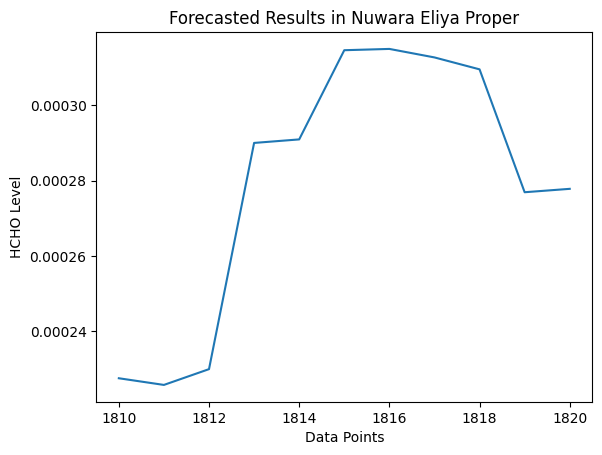

In [ ]:
# Forecasted Results
plt.title("Forecasted Results in Nuwara Eliya Proper")
plt.xlabel('Data Points')
plt.ylabel('HCHO Level')
plt.plot(forecast_10days)

### Kandy proper

#### Data Splitting

In [ ]:
#Splitting the dataset into train and test sets
split_ratio = 0.8 

kandy_data = HCHO_data[HCHO_data['Location'] == 'Kandy Proper']
train_size = int(len(kandy_data) * split_ratio)
train_data_kandy, test_data_kandy = kandy_data[0:train_size], kandy_data[train_size:]

print("Full Data Size:-", kandy_data.shape)
print("Train Data Size :-", train_data_kandy.shape)
print("Test Data Size :-", test_data_kandy.shape)

Full Data Size:- (1781, 3)
Train Data Size :- (1424, 3)
Test Data Size :- (357, 3)


#### Model Training and Evaluation

In [ ]:
# Fitting the SARIMA Model
# Fit SARIMA model to the training data
sarima_model = SARIMAX(train_data_kandy['HCHO Reading'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()

# Generate forecasts for the test set
test_forecast = sarima_result.forecast(steps=len(test_data_kandy))

# Calculate evaluation metrics
mse = mean_squared_error(test_data_kandy['HCHO Reading'], test_forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_kandy['HCHO Reading'], test_forecast)

# Print evaluation metrics
print("\nEvaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")



Evaluation Metrics:
Mean Squared Error (MSE): 4.4687561262645467e-07
Root Mean Squared Error (RMSE): 0.0006684875560744977
Mean Absolute Error (MAE): 0.0005969033994160204


#### Forecasting next 10 days

In [ ]:
# Generate forecasts for the next 10 days by fitting entire dataset for the model
sarima_model = SARIMAX(kandy_data['HCHO Reading'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()

forecast_10days = sarima_result.forecast(steps=11)

# Print the forecasted values
print("\nForecasted HCHO levels for the next 10 days:")
print(forecast_10days)


Forecasted HCHO levels for the next 10 days:
1781   -0.000002
1782    0.000047
1783    0.000024
1784    0.000176
1785    0.000171
1786    0.000082
1787    0.000090
1788    0.000087
1789    0.000083
1790    0.000071
1791    0.000064
Name: predicted_mean, dtype: float64


#### Plotting and Results

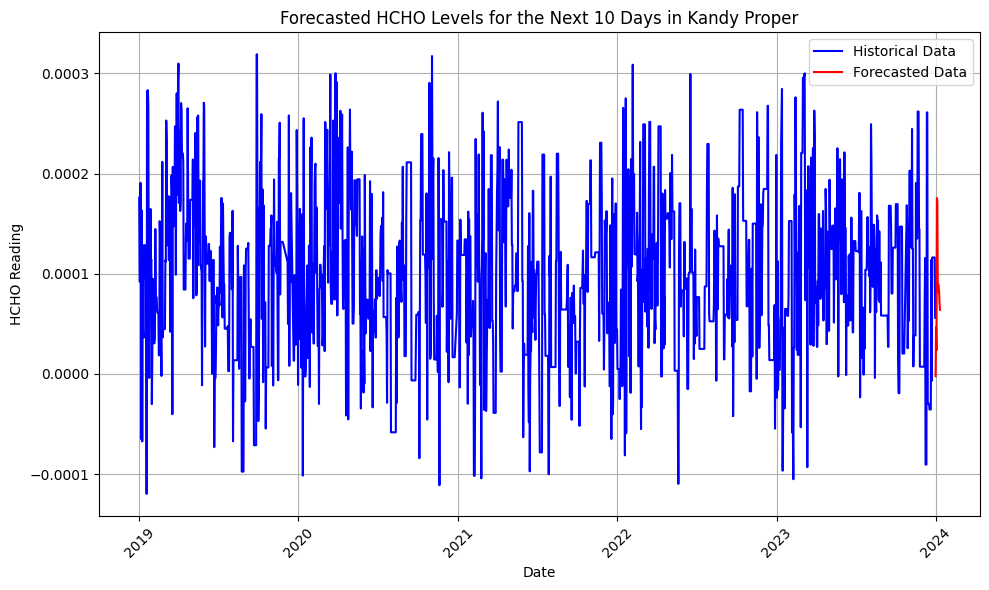

In [ ]:
# Plot historical data
plt.figure(figsize=(10, 6))
plt.plot(kandy_data.index, kandy_data['HCHO Reading'], label='Historical Data', color='blue')

# Plot forecasted values for the next 10 days
forecast_dates = pd.date_range(start=kandy_data.index[-1], periods=11)
plt.plot(forecast_dates, forecast_10days, label='Forecasted Data', color='red')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.title('Forecasted HCHO Levels for the Next 10 Days in Kandy Proper')
plt.legend()
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()


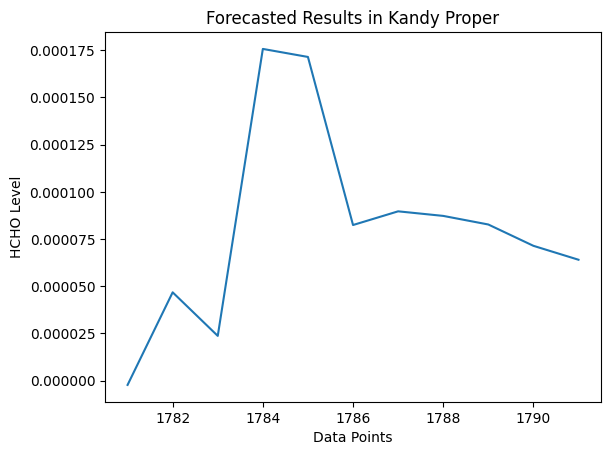

In [ ]:
# Forecasted Results
plt.title("Forecasted Results in Kandy Proper")
plt.xlabel('Data Points')
plt.ylabel('HCHO Level')
plt.plot(forecast_10days)

### Kurunegala Proper

#### Splitting the Data

In [ ]:
#Splitting the dataset into train and test sets
split_ratio = 0.8 

kurunegala_data = HCHO_data[HCHO_data['Location'] == 'Kurunegala Proper']
train_size = int(len(kurunegala_data) * split_ratio)
train_data_kurunegala, test_data_kurunegala = kurunegala_data[0:train_size], kurunegala_data[train_size:]

print("Full Data Size:-", kurunegala_data.shape)
print("Train Data Size :-", train_data_kurunegala.shape)
print("Test Data Size :-", test_data_kurunegala.shape)

Full Data Size:- (1764, 3)
Train Data Size :- (1411, 3)
Test Data Size :- (353, 3)


#### Model Training and Evaluation

In [ ]:
# Fitting the SARIMA Model
# Fit SARIMA model to the training data
sarima_model = SARIMAX(train_data_kurunegala['HCHO Reading'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()

# Generate forecasts for the test set
test_forecast = sarima_result.forecast(steps=len(test_data_kurunegala))

# Calculate evaluation metrics
mse = mean_squared_error(test_data_kurunegala['HCHO Reading'], test_forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_kurunegala['HCHO Reading'], test_forecast)

# Print evaluation metrics
print("\nEvaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")



Evaluation Metrics:
Mean Squared Error (MSE): 5.117386092678187e-07
Root Mean Squared Error (RMSE): 0.0007153590771548361
Mean Absolute Error (MAE): 0.0006402395737034386


#### Forecasting Next 10 Days

In [ ]:
# Generate forecasts for the next 10 days by fitting entire dataset for the model
sarima_model = SARIMAX(kurunegala_data['HCHO Reading'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()

forecast_10days = sarima_result.forecast(steps=11)

# Print the forecasted values
print("\nForecasted HCHO levels for the next 10 days:")
print(forecast_10days)


Forecasted HCHO levels for the next 10 days:
1764    0.000176
1765    0.000113
1766    0.000125
1767    0.000128
1768    0.000136
1769    0.000095
1770    0.000159
1771    0.000113
1772    0.000126
1773    0.000055
1774    0.000090
Name: predicted_mean, dtype: float64


#### Plotting the Results

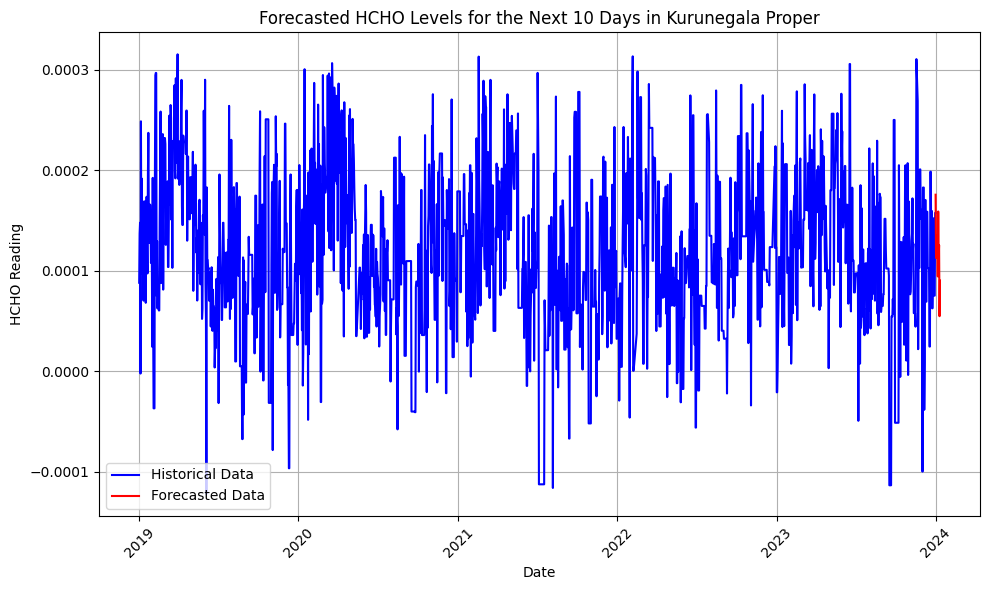

In [ ]:
# Plot historical data
plt.figure(figsize=(10, 6))
plt.plot(kurunegala_data.index, kurunegala_data['HCHO Reading'], label='Historical Data', color='blue')

# Plot forecasted values for the next 10 days
forecast_dates = pd.date_range(start=kurunegala_data.index[-1], periods=11)
plt.plot(forecast_dates, forecast_10days, label='Forecasted Data', color='red')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.title('Forecasted HCHO Levels for the Next 10 Days in Kurunegala Proper')
plt.legend()
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()


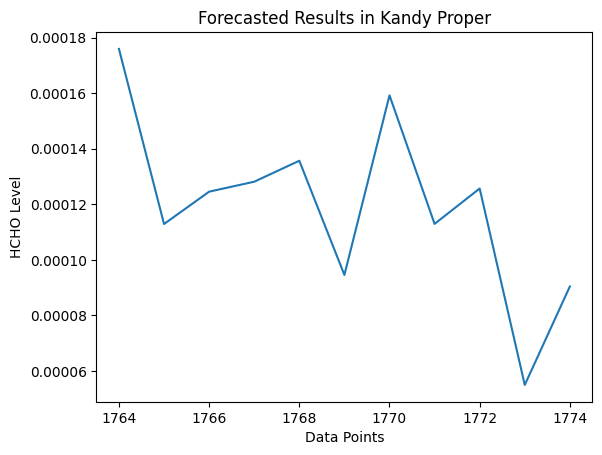

In [ ]:
# Forecasted Results
plt.title("Forecasted Results in Kandy Proper")
plt.xlabel('Data Points')
plt.ylabel('HCHO Level')
plt.plot(forecast_10days)

### Bibile, Monaragala

#### Splitting the Data

In [ ]:
#Splitting the dataset into train and test sets
split_ratio = 0.8 

bibile_data = HCHO_data[HCHO_data['Location'] == 'Bibile, Monaragala']
train_size = int(len(bibile_data) * split_ratio)
train_data_bibile, test_data_bibile = bibile_data[0:train_size], kurunegala_data[train_size:]

print("Full Data Size:-", bibile_data.shape)
print("Train Data Size :-", train_data_bibile.shape)
print("Test Data Size :-", test_data_bibile.shape)

Full Data Size:- (1747, 3)
Train Data Size :- (1397, 3)
Test Data Size :- (367, 3)


#### Model Creation and Evaluation

In [ ]:
# Fitting the SARIMA Model
# Fit SARIMA model to the training data
sarima_model = SARIMAX(train_data_bibile['HCHO Reading'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()

# Generate forecasts for the test set
test_forecast = sarima_result.forecast(steps=len(test_data_bibile))

# Calculate evaluation metrics
mse = mean_squared_error(test_data_bibile['HCHO Reading'], test_forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data_bibile['HCHO Reading'], test_forecast)

# Print evaluation metrics
print("\nEvaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")



Evaluation Metrics:
Mean Squared Error (MSE): 7.867919961705432e-07
Root Mean Squared Error (RMSE): 0.0008870129627973558
Mean Absolute Error (MAE): 0.0008013281610666605


#### Forecasting next 10 Days

In [ ]:
# Generate forecasts for the next 10 days by fitting entire dataset for the model
sarima_model = SARIMAX(bibile_data['HCHO Reading'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = sarima_model.fit()

forecast_10days = sarima_result.forecast(steps=11)

# Print the forecasted values
print("\nForecasted HCHO levels for the next 10 days:")
print(forecast_10days)


Forecasted HCHO levels for the next 10 days:
1747    0.000016
1748    0.000062
1749    0.000079
1750    0.000116
1751    0.000123
1752    0.000085
1753    0.000052
1754    0.000050
1755    0.000049
1756    0.000043
1757    0.000004
Name: predicted_mean, dtype: float64


#### Plotting Results

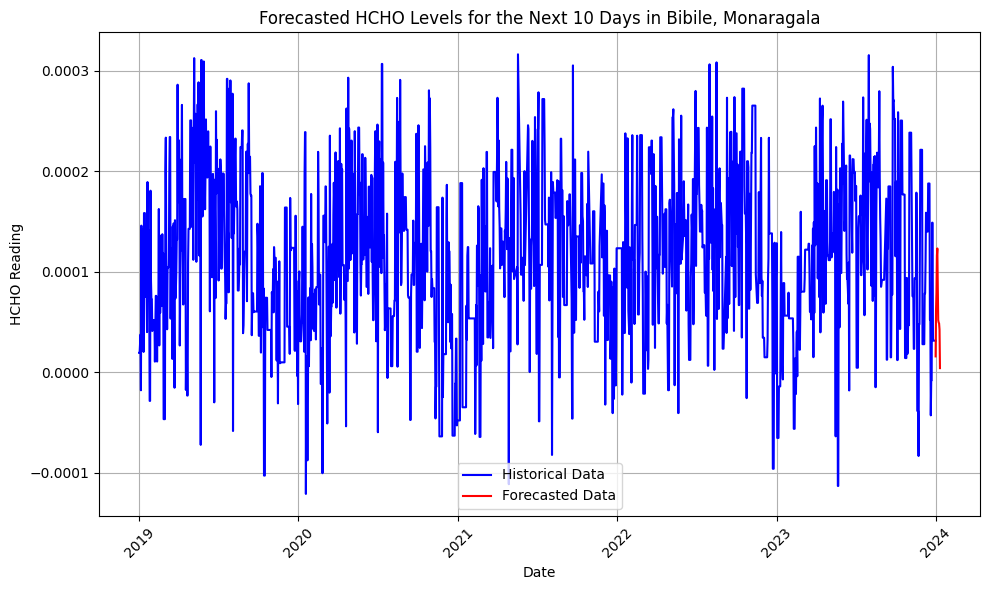

In [ ]:
# Plot historical data
plt.figure(figsize=(10, 6))
plt.plot(bibile_data.index, bibile_data['HCHO Reading'], label='Historical Data', color='blue')

# Plot forecasted values for the next 10 days
forecast_dates = pd.date_range(start=bibile_data.index[-1], periods=11)
plt.plot(forecast_dates, forecast_10days, label='Forecasted Data', color='red')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('HCHO Reading')
plt.title('Forecasted HCHO Levels for the Next 10 Days in Bibile, Monaragala')
plt.legend()
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()


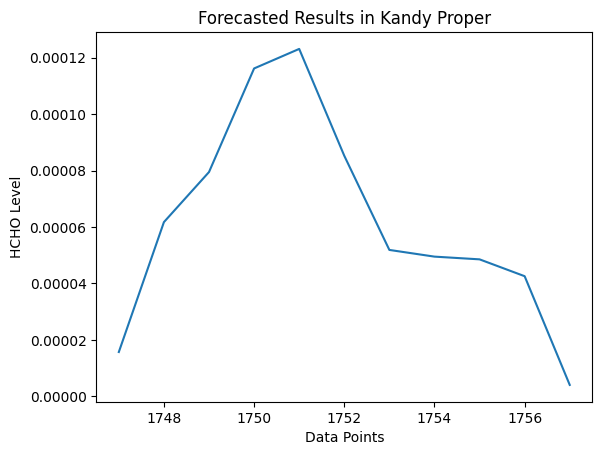

In [ ]:
# Forecasted Results
plt.title("Forecasted Results in Kandy Proper")
plt.xlabel('Data Points')
plt.ylabel('HCHO Level')
plt.plot(forecast_10days)